In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
from keras.utils import np_utils

In this tutorial I used tensorflow for classification on cifar10 dataset. I used my laptop Lenovo Y700 with Nvidia GTX 960M graphic card for training. you can use cloud services and train more and get better results. In Iran we do not have access to cloud services :)

In [48]:
tf.__version__

'1.0.0'

In [49]:
cifar10.data_path = "data/cifar-10-python/cifar-10-batches-py/"

you can download cifar10 dataset from this link (http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz) or just use keras to download it.

In [55]:
(images_train, labels_train), (images_test, labels_test) = cifar10.load_data()

In [56]:
labels_train = np_utils.to_categorical(labels_train)
labels_test = np_utils.to_categorical(labels_test)

In [57]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [58]:
print("train dataset shapes:")
print("images_train shape:",images_train.shape)
print("labels_train: shape",labels_train.shape)

train dataset shapes:
images_train shape: (50000, 32, 32, 3)
labels_train: shape (50000, 10)


In [59]:
print("test dataset shapes:")
print("images_test shape:",images_test.shape)
print("labels_test: shape",labels_test.shape)

test dataset shapes:
images_test shape: (10000, 32, 32, 3)
labels_test: shape (10000, 10)


In [60]:
## normalization
images_train = images_train.astype('float32')
images_train = images_train/255.
images_test = images_test.astype('float32')
images_test = images_test/255.

In [61]:
height = images_train.shape[1]
width = images_train.shape[2]
depth = images_train.shape[3]
num_classes = labels_train.shape[1]

# helper functions

In [62]:
def weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [63]:
def biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [64]:
def conv2d_layer(imgs,              # The previous layer.
                    num_input_channels, # Num. channels in prev. layer.
                    filter_size,        # Width and height of each filter.
                    num_filters,        # Number of filters.
                    stride,             
                    padding): 

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    kernel = weights(shape=shape)

    # Create new biases, one for each filter.
    biase = biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=imgs,
                         filter=kernel,
                         strides=[1, stride, stride, 1],
                         padding=padding)

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biase


    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, kernel

In [65]:
def max_pool_layer(layer, window_size, stride, padding):
    # Use pooling to down-sample the image resolution
    # This is 2x2 max-pooling, which means that we
    # consider 2x2 windows and select the largest value
    # in each window. Then we move 2 pixels to the next window.
    max_pooled_layer = tf.nn.max_pool(value=layer,
                           ksize=[1, window_size, window_size, 1],
                           strides=[1, stride, stride, 1],
                           padding=padding)
    return max_pooled_layer

In [66]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [67]:
def fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weight = weights(shape=[num_inputs, num_outputs])
    biase = biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weight) + biase

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [68]:
def random_batch(train_batch_size):
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

# placeholders

In [69]:
x = tf.placeholder(tf.float32, shape=[None,height,width,depth], name="X")
y_true = tf.placeholder(tf.float32, shape=[None,num_classes], name="Y")

In [70]:
y_true_cls = tf.argmax(y_true, dimension=1)

# define network

In [71]:
conv1_depth = 16
conv2_depth = 32
conv3_depth = 64

In [72]:
conv1, _ = conv2d_layer(x, depth, 3, conv1_depth, 1, 'SAME')
max_pool1 = max_pool_layer(conv1, 2, 2, 'SAME')

conv2, _ = conv2d_layer(max_pool1, conv1_depth, 3, conv2_depth, 1, 'SAME')
max_pool2 = max_pool_layer(conv2, 2, 2, 'SAME')

conv3, _ = conv2d_layer(max_pool2, conv2_depth, 3, conv3_depth, 1, 'SAME')
max_pool3 = max_pool_layer(conv3, 2, 2, 'SAME')

flatten, num_features = flatten_layer(max_pool3)

FC1 = fc_layer(flatten, num_features, 1024, True)
FC1_dropped = tf.nn.dropout(FC1, 0.5)
FC2 = fc_layer(FC1_dropped, 1024, num_classes, False)
y_pred = tf.nn.softmax(FC2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# Loss function

In [73]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=FC2)
cost = tf.reduce_mean(cross_entropy)

# optimization method

In [74]:
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

# performance measurment

In [75]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [76]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Training

In [77]:
sess = tf.InteractiveSession()

In [78]:
sess.run(tf.global_variables_initializer())

In [79]:
for i in range(2000):
    x_batch, y_true_batch = random_batch(500)
    sess.run(optimizer, feed_dict={x: x_batch, y_true: y_true_batch})
    if i%500 == 0:
        acc = sess.run(accuracy, feed_dict={x: x_batch, y_true: y_true_batch})
        acc_test = sess.run(accuracy, feed_dict={x:images_test , y_true:labels_test})
        print("iter:{0}, train acc:{1}, test acc:{2}".format(i, acc, acc_test))

iter:0, train acc:0.12200000137090683, test acc:0.09749999642372131
iter:500, train acc:0.3960000276565552, test acc:0.4258999228477478
iter:1000, train acc:0.47199997305870056, test acc:0.48629987239837646
iter:1500, train acc:0.5479999780654907, test acc:0.5188998579978943


In [80]:
## another 6000 training epochs
for i in range(6000):
    x_batch, y_true_batch = random_batch(500)
    sess.run(optimizer, feed_dict={x: x_batch, y_true: y_true_batch})
    if i%500 == 0:
        acc = sess.run(accuracy, feed_dict={x: x_batch, y_true: y_true_batch})
        acc_test = sess.run(accuracy, feed_dict={x:images_test , y_true:labels_test})
        print("iter:{0}, train acc:{1}, test acc:{2}".format(i, acc, acc_test))

iter:0, train acc:0.5419999957084656, test acc:0.5406998991966248
iter:500, train acc:0.5799999833106995, test acc:0.5656999349594116
iter:1000, train acc:0.5760000348091125, test acc:0.5789998769760132
iter:1500, train acc:0.6359999775886536, test acc:0.5857999324798584
iter:2000, train acc:0.6360000371932983, test acc:0.5988999009132385
iter:2500, train acc:0.6279999613761902, test acc:0.6079999208450317
iter:3000, train acc:0.6460000276565552, test acc:0.6129999756813049
iter:3500, train acc:0.64000004529953, test acc:0.6286999583244324
iter:4000, train acc:0.6859999895095825, test acc:0.6296998858451843
iter:4500, train acc:0.7000000476837158, test acc:0.6315999031066895
iter:5000, train acc:0.687999963760376, test acc:0.6464999318122864
iter:5500, train acc:0.7099999785423279, test acc:0.6518998742103577


My laptop graphic card became so hot. You can train the network more to reach more accuracy.

In [81]:
pred = sess.run(y_pred_cls, feed_dict={x:images_test})

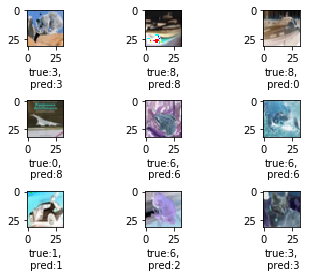

In [88]:
fig, axes = plt.subplots(3,3)
fig.subplots_adjust(hspace=1.5, wspace=0.2)
for i,ax in enumerate(axes.flat):
    ax.imshow(images_test[i]*255.)
    ax.set_xlabel("true:{0},\n pred:{1}".format(np.argmax(labels_test[i]),pred[i]))
plt.show()